# Multi-class semantic segmentation

> For the multi-class semantic segmentation task, we will use the brain tumors dataset from the Medical Segmentation Decathlon challenge (http://medicaldecathlon.com/). The data is collected from the Multimodal Brain Tumor Image Segmentation Benchmark Challenge (BraTS) dataset from 2016 and 2017. The task is to segment tumors into three different subregions (active tumor (AT), necrotic core (NCR), and peritumoral edematous/infiltrated tissue (ED)) from multimodal multisite MRI data (T1w, T1ce, T2w, and FLAIR). The challenge with this dataset is the brain tumors' highly heterogeneous appearance and shape.

[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/fastMONAI/blob/master/nbs/10d_tutorial_multiclass_segmentation.ipynb)

In [ ]:
#| hide
#Install `fastMONAI` if notebook is running on Google Colab
try:
    import google.colab
    %pip install fastMONAI
    from fastMONAI.utils import print_colab_gpu_info
    print_colab_gpu_info()
except:
    print('Running locally')

Running locally


In [ ]:
from fastMONAI.vision_all import *

from monai.apps import DecathlonDataset
from sklearn.model_selection import train_test_split

### Download external data

We use the MONAI function `DecathlonDataset` to download the data and generate items for training. 

In [ ]:
path = Path('../data')
path.mkdir(exist_ok=True)

In [ ]:
task = "Task01_BrainTumour"
training_data = DecathlonDataset(root_dir=path, task=task, section="training", download=True,
                                 cache_num=0, num_workers=3)

2025-08-29 09:44:58,814 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2025-08-29 09:44:58,815 - INFO - File exists: ../data/Task01_BrainTumour.tar, skipped downloading.
2025-08-29 09:44:58,816 - INFO - Non-empty folder exists in ../data/Task01_BrainTumour, skipped extracting.


In [ ]:
df = pd.DataFrame(training_data.data)
df.shape

(388, 2)

Split the labled data into training and test

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df.shape, test_df.shape

((349, 2), (39, 2))

### Look at training data

In [ ]:
med_dataset = MedDataset(img_list=train_df.label.tolist(), dtype=MedMask, max_workers=12)

In [ ]:
med_dataset.df.head()

,path,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,voxel_count_0,voxel_count_1,voxel_count_2,voxel_count_3
0,../data/Task01_BrainTumour/labelsTr/BRATS_477.nii.gz,240,240,155,1.0,1.0,1.0,RAS+,8765377,83088,15826,63709.0
1,../data/Task01_BrainTumour/labelsTr/BRATS_350.nii.gz,240,240,155,1.0,1.0,1.0,RAS+,8872636,21364,8872,25128.0
2,../data/Task01_BrainTumour/labelsTr/BRATS_266.nii.gz,240,240,155,1.0,1.0,1.0,RAS+,8725071,83276,69784,49869.0
3,../data/Task01_BrainTumour/labelsTr/BRATS_294.nii.gz,240,240,155,1.0,1.0,1.0,RAS+,8790699,90806,20231,26264.0
4,../data/Task01_BrainTumour/labelsTr/BRATS_466.nii.gz,240,240,155,1.0,1.0,1.0,RAS+,8911252,14046,60,2642.0


In [ ]:
summary_df = med_dataset.summary()

In [ ]:
summary_df.head()

,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,example_path,total
0,240,240,155,1.0,1.0,1.0,RAS+,../data/Task01_BrainTumour/labelsTr/BRATS_002.nii.gz,349


In [ ]:
resample, reorder = med_dataset.suggestion()
resample, reorder

([1.0, 1.0, 1.0], False)

In [ ]:
img_size = med_dataset.get_largest_img_size(resample=resample)
img_size

[240.0, 240.0, 155.0]

In [ ]:
bs=4
size=[224,224,128]

In [ ]:
item_tfms = [ZNormalization(), PadOrCrop(size), RandomAffine(scales=0, degrees=5, isotropic=True)] 

In [ ]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), MedMaskBlock), 
                      splitter=RandomSplitter(seed=42),
                      get_x=ColReader('image'),
                      get_y=ColReader('label'),
                      item_tfms=item_tfms,
                      reorder=reorder,
                      resample=resample) 

In [ ]:
dls = dblock.dataloaders(train_df, bs=bs)

In [ ]:
# training and validation
len(dls.train_ds.items), len(dls.valid_ds.items)

(280, 69)

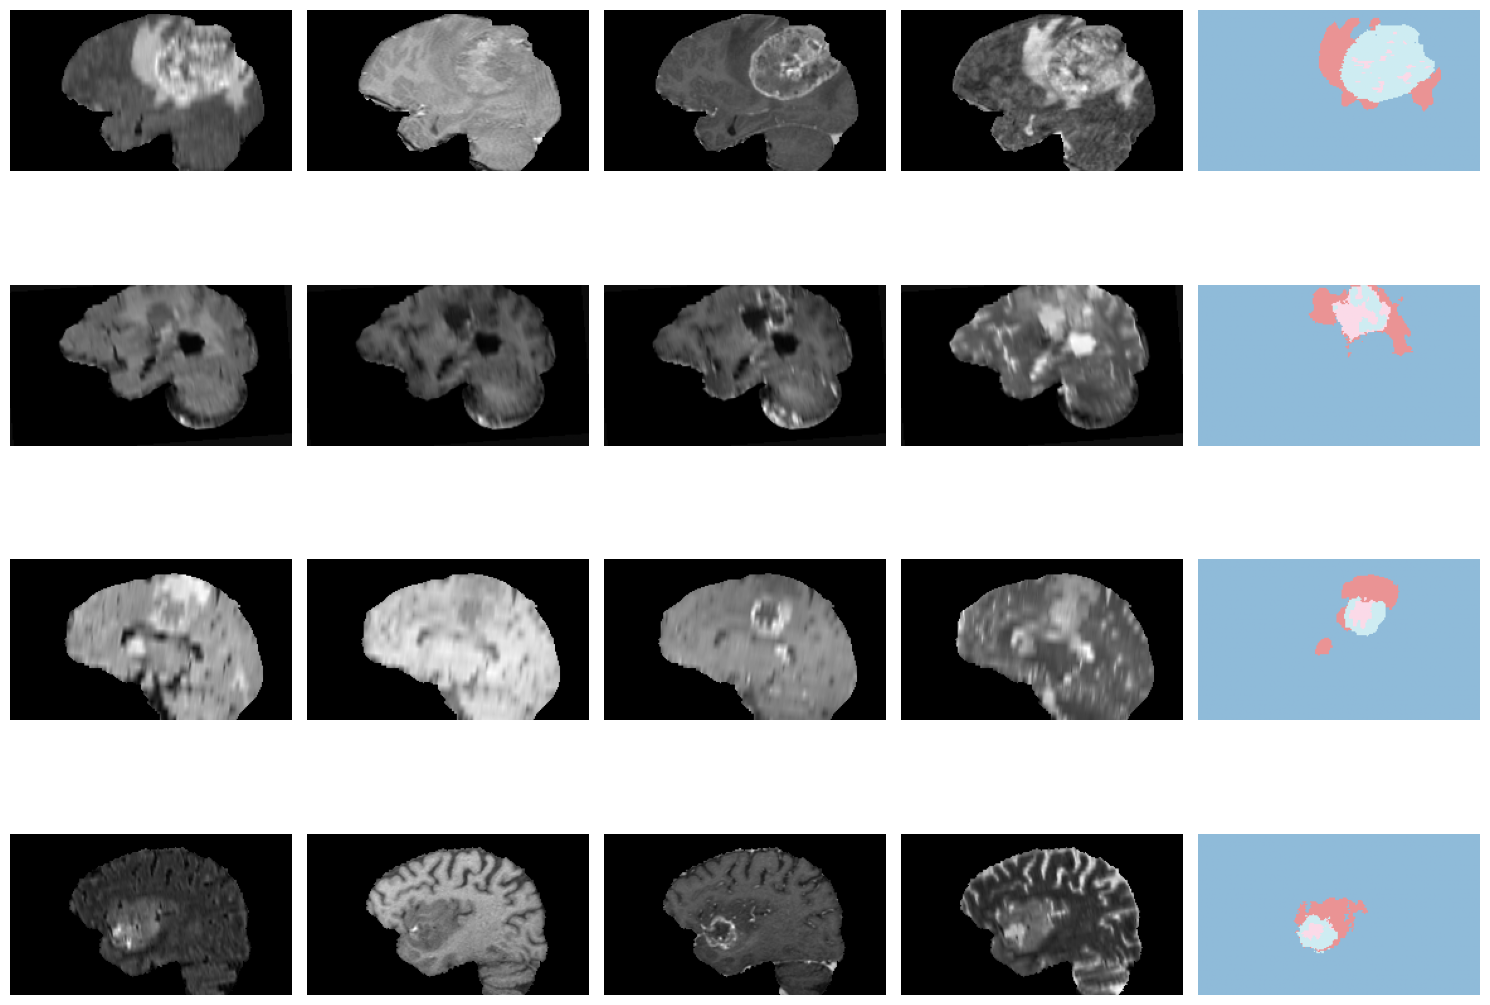

In [ ]:
dls.show_batch(anatomical_plane=0) 

### Create and train a 3D model

As in the binary segmentation task, we import an enhanced version of UNet from MONAI. This time instead of using Dice loss, we import a loss function that combines Dice loss and Cross Entropy loss and returns the weighted sum of these two losses. 

In [ ]:
from monai.losses import DiceCELoss
from monai.networks.nets import UNet

In [ ]:
codes = np.unique(med_img_reader(train_df.label.tolist()[0]))
n_classes = len(codes)
print("Unique classes:",*codes)

Unique classes: 0.0 1.0 2.0 3.0


In [ ]:
monai_model = UNet(spatial_dims=3, in_channels=4, out_channels=n_classes, channels=(16, 32, 64, 128, 256),strides=(2, 2, 2, 2), num_res_units=2)
pytorch_model = monai_model.model

In [ ]:
loss_func = CustomLoss(loss_func=DiceCELoss(to_onehot_y=True, include_background=True, softmax=True))

In [ ]:
learn = Learner(dls, monai_model, loss_func=loss_func, opt_func=ranger, metrics=multi_dice_score)#.to_fp16()

SuggestedLRs(valley=0.001737800776027143)

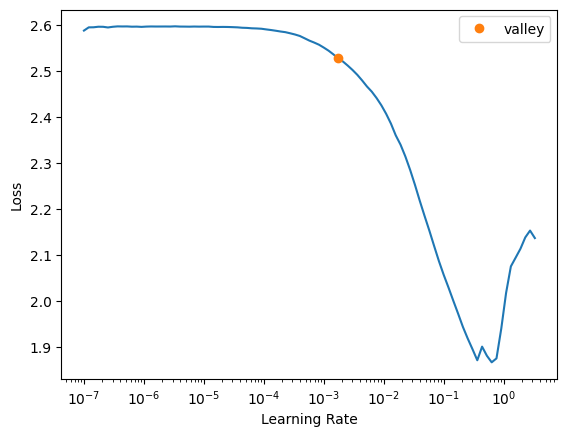

In [ ]:
learn.lr_find()

In [ ]:
lr = 1e-1

In [ ]:
import mlflow

# Set experiment name
mlflow.set_experiment(task)

mlflow_callback = ModelTrackingCallback(
    model_name=f"{task}_{monai_model._get_name()}",
    loss_function=loss_func.loss_func._get_name(),
    item_tfms=item_tfms,
    size=size,
    resample=resample,
    reorder=reorder,
)

with mlflow.start_run(run_name="initial_training"):
    learn.fit_flat_cos(2, lr, cbs=[mlflow_callback])

In [ ]:
learn.save('braintumor-weights')

Path('models/braintumor-model.pth')

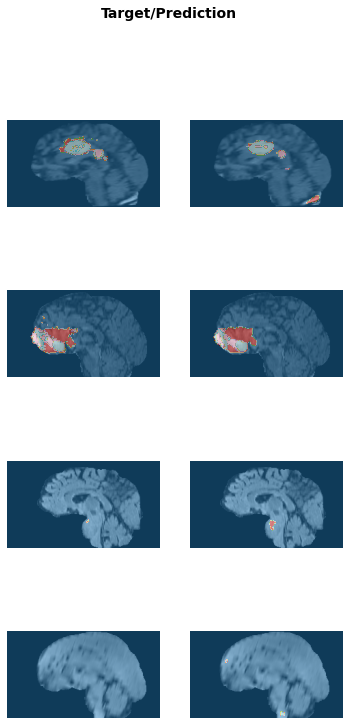

In [ ]:
learn.show_results(anatomical_plane=0, ds_idx=1)

### Inference on test data

In [ ]:
learn.load('braintumor-weights');

In [ ]:
test_dl = learn.dls.test_dl(test_df[:10],with_labels=True)

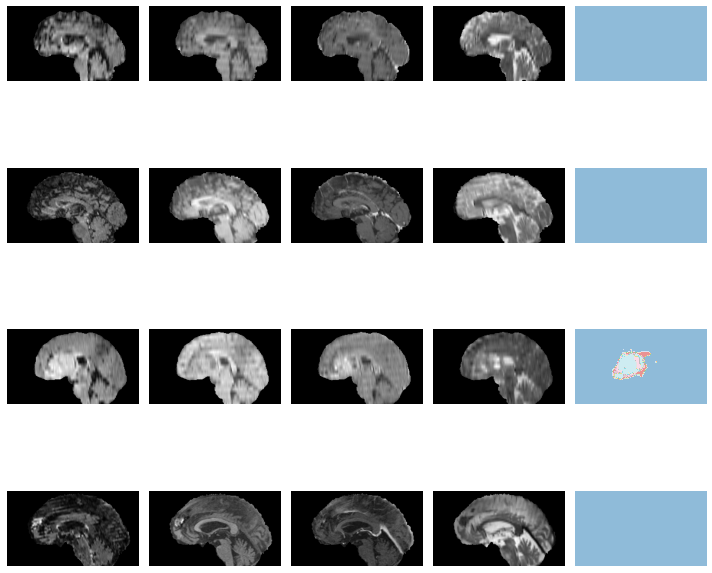

In [ ]:
test_dl.show_batch(anatomical_plane=0, figsize=(10,10))

In [ ]:
pred_acts, labels = learn.get_preds(dl=test_dl)
pred_acts.shape, labels.shape

(torch.Size([10, 4, 224, 224, 128]), torch.Size([10, 1, 224, 224, 128]))

Dice score for labels 1,2 and 3: 

In [ ]:
multi_dice_score(pred_acts, labels)

tensor([0.5708, 0.4186, 0.6994])

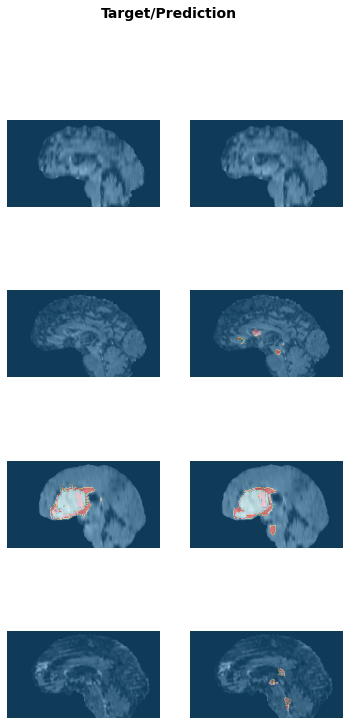

In [ ]:
learn.show_results(anatomical_plane=0, dl=test_dl)

### Export learner  

In [ ]:
model_artifact_path = Path(f'model_artifacts/{task}')
model_artifact_path.mkdir(parents=True, exist_ok=True)

In [ ]:
store_variables(pkl_fn=model_artifact_path/'model_config.pkl', size=size, reorder=reorder,  resample=resample)

In [ ]:
learn.export(model_artifact_path/'segmentation_unet_learner.pkl')